# <span style="font-weight:bold; color:#252525">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</span> <span><img src="https://s.glbimg.com/en/ho/static/globo_com_2016/img/home_200x200.png" alt="Globo.com" style="display:inline; vertical-align:baseline;height:150px;"></img></span>

# Teste Técnico - CartolaFC 
### Luiz Guilherme Monteiro - lgmonteiro7@gmail.com

## Contexto

O Cartola FC é um "fantasy game" sobre futebol, ou seja, é um jogo online fictício no qual você pode montar seu time com jogadores reais da Série A do Campeonato Brasileiro.

A disputa é realizada com seus amigos e outros cartoleiros de todo o Brasil.
Ao se cadastrar no jogo é preciso montar seu time, escolhendo nome, técnico, camisa e escudo. 

Com as cartoletas (moeda exclusiva do Cartola FC) é possível escalar o seu time, comprando e vendendo jogadores a cada rodada. A escalação deve ser feita enquanto o mercado estiver aberto (o mercado fecha 2 horas antes do primeiro jogo da rodada).

A cada rodada, os jogadores recebem pontuações baseadas em suas ações durante as partidas (ex: gols feitos, chutes defendidos, bolas roubadas, faltas cometidas ou sofridas, cartões recebidos, etc.).

## Objetivos

* Fazer uma análise exploratória dos dados com o objetivo de encontrar informações úteis para identificação de perfis de usuários propensos a assinarem o Cartola. 

* Ajustar um modelo preditivo simples para identificar os perfis de usuários propensos a assinarem o Cartola. 

# 0.0 Preparação do ambiente

In [1]:
import shap
import warnings
import numpy as np
import pandas as pd
import ppscore as pps
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from yellowbrick.classifier import ROCAUC
from bayes_opt import BayesianOptimization
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from yellowbrick.classifier import ConfusionMatrix
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport

%matplotlib inline
sns.set(style="ticks", color_codes=True)
shap.initjs()
warnings.filterwarnings('ignore')

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.


# 1.0 Preparação dos dados

## 1.1 Carregamento dos dados e análise estrutural 

In [2]:
df_raw = pd.read_csv("./data/raw/ge_df_users_editorias_02.csv")
treated_df = df_raw.copy()
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50689 entries, 0 to 50688
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user                  50689 non-null  int64  
 1   sexo                  22440 non-null  object 
 2   uf                    21559 non-null  object 
 3   idade                 22616 non-null  float64
 4   dias                  50689 non-null  int64  
 5   pviews                50689 non-null  int64  
 6   visitas               50689 non-null  int64  
 7   tempo_total           50689 non-null  float64
 8   device                50689 non-null  object 
 9   futebol               50689 non-null  float64
 10  futebol_intenacional  50689 non-null  float64
 11  futebol_olimpico      50689 non-null  float64
 12  blog_cartola          50689 non-null  float64
 13  atletismo             50689 non-null  float64
 14  ginastica             50689 non-null  float64
 15  judo               

* Fica claro que existem dados faltantes em algumas colunas.

* Os tipos não apresentam problemas.

## 1.2 Outliers

In [3]:
outliers_measuring = df_raw.copy().dropna()
features_columns = [c for c in outliers_measuring.columns if c not in ('user', 'sexo', 'uf', 'cartola_status','device')]
# Uso do algoritmo de Isolation Forest para detecção da quantidade de outliers
clf = IsolationForest(
    random_state=42,
    contamination='auto',
    n_jobs=-1
)

preds = clf.fit_predict(outliers_measuring[features_columns].values)

print("Porcentagem de outliers na base: %.2f%%" % ((list(preds).count(-1) / outliers_measuring.shape[0]) * 100))


Porcentagem de outliers na base: 6.89%


* Como a proporção de outliers é considerável, precisamos escolher uma estratégia que leve em consideração esse fator na modelagem. Trataremos isso na normalização.

## 1.3 Análise dos dados faltantes

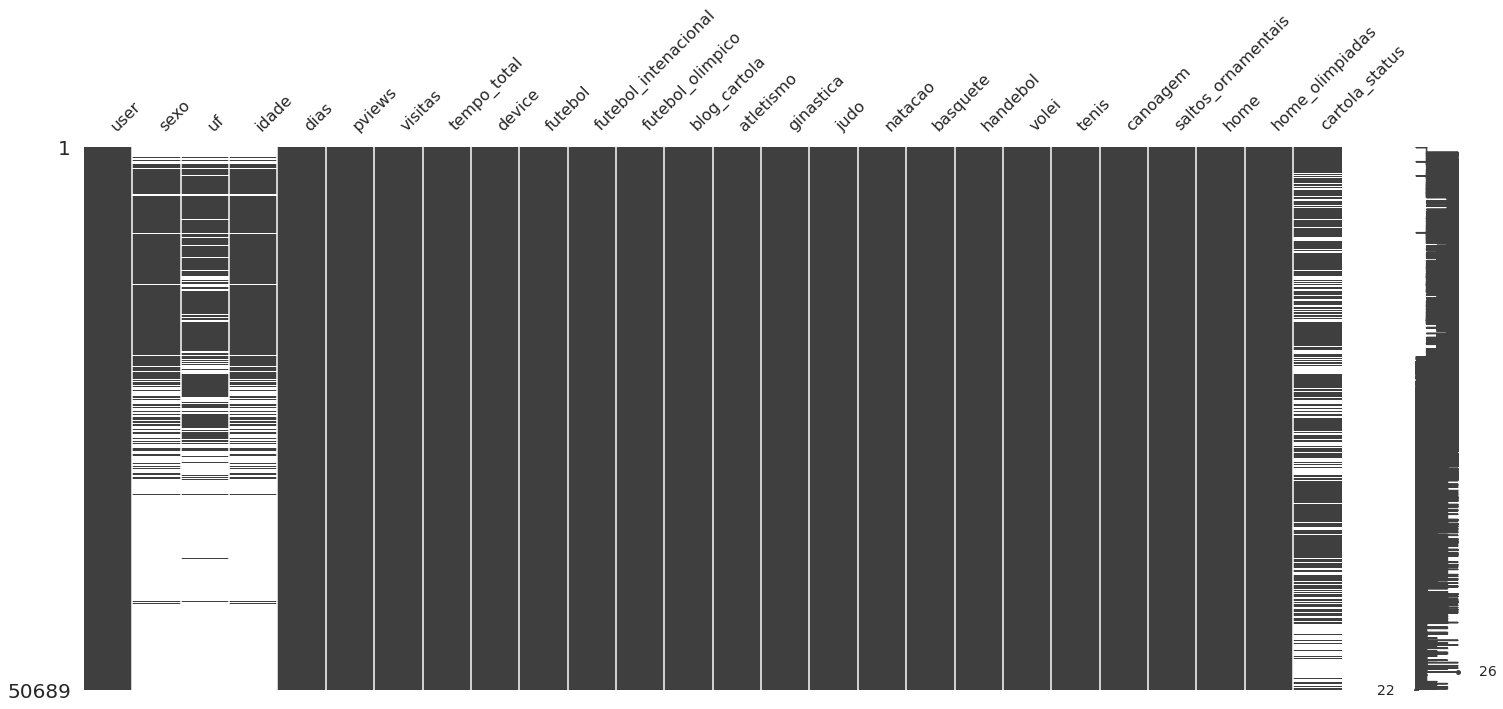

In [4]:
msno.matrix(df_raw)

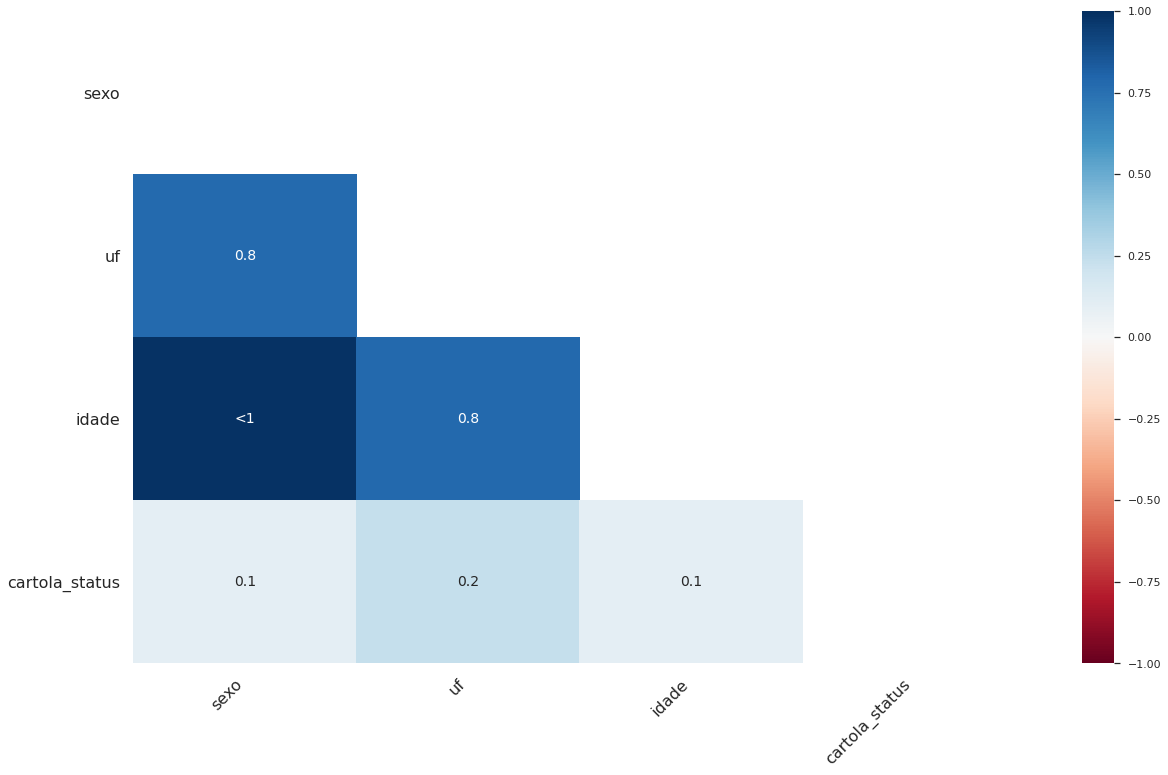

In [5]:
msno.heatmap(df_raw) 


* Aparentemente existe a possibilidade de se cadastrar sem informar dados pessoais como gênero, sexo e idade.
* Existe forte correlação entre quem escolhe não informar um desses campos pessoais, não informar os outros dois.

## 1.4 Tratamento dos dados faltantes


## 1.4.1 Tratamento da idade

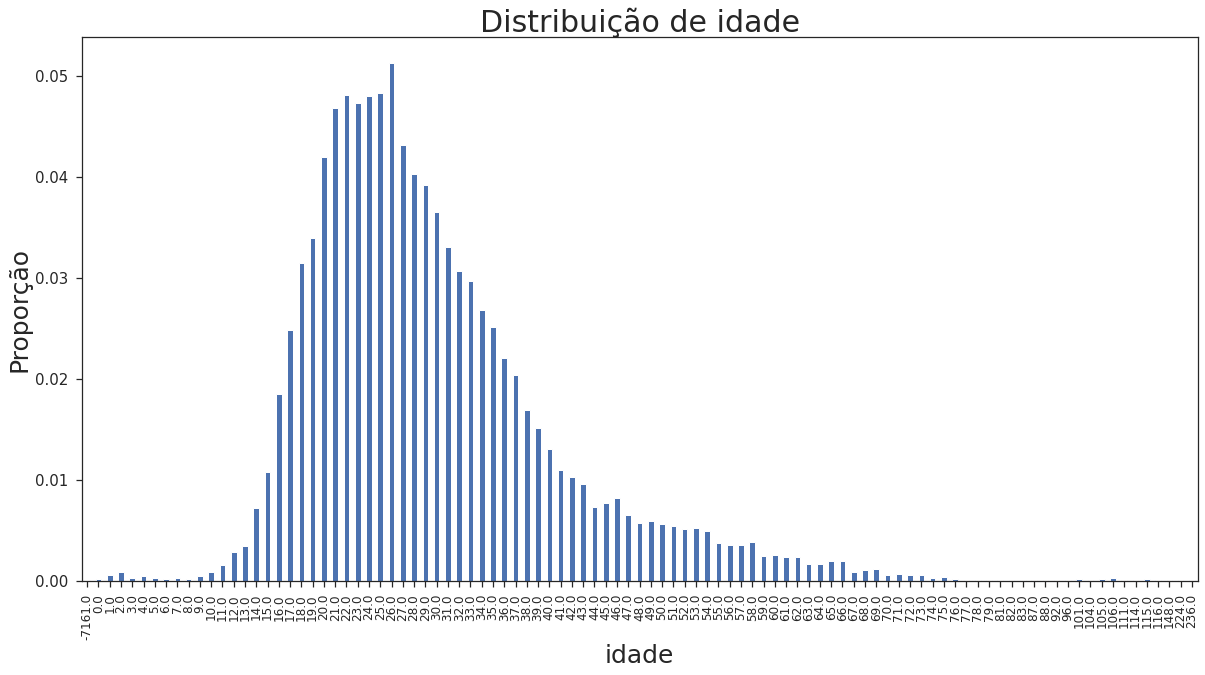

In [6]:
#Verificando a distribuição
fig, ax = plt.subplots(figsize=(20, 10))
plt.title('Distribuição de idade', fontsize = 30)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 15)
plt.ylabel('Proporção', fontsize = 25)
plt.xlabel('idade', fontsize = 25)
df_raw.idade.value_counts(sort = True, normalize = True).sort_index().plot(kind='bar')


* Temos uma distribuição de Landau.
* Considerando a distribuição como uma distribuição de probabilidade podemos preencher os dados faltantes de idade do nosso dataset

In [7]:
#Gerarando um sample que corresponda aos dados faltantes na idade e que leve em consideração a distribuição
distribution_prob = df_raw[df_raw['idade'].between(10, 90, inclusive=True)].idade.value_counts(sort = True, normalize = True).tolist()
possible_ages = df_raw[df_raw['idade'].between(10, 90, inclusive=True)].idade.value_counts(sort = True, normalize = True).keys().tolist()
possible_ages = [int(x) for x in possible_ages]
ages = list()

#Aplicando a distribuição somente onde houver dado faltante ou outlier
for item in df_raw.itertuples():
    if (10<item.idade<90):
        ages.append(int(item.idade))
    else:
        ages.append(np.random.choice(possible_ages,1,p=distribution_prob)[0])
        
# Movendo a lista para o dataset 
df_age_fixed = df_raw.copy()
df_age_fixed['idade'] = ages
treated_df['idade'] = df_age_fixed.idade.values

## 1.4.2 Tratamento do gênero

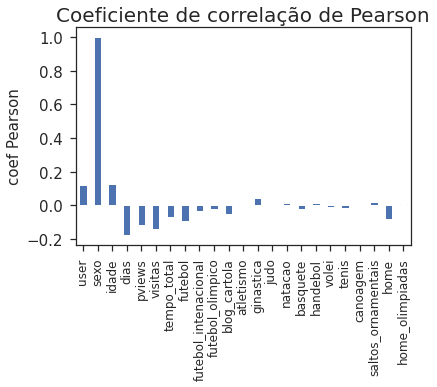

In [8]:
#Vamos ver se o sexo tem correlação linear com algum comportamento
df_sex = df_age_fixed.copy()
df_sex['sexo'] = df_sex.sexo.replace('M', -1)
df_sex['sexo'] = df_sex.sexo.replace('F', 1)
corr = df_sex.corr()
corr['sexo'].plot(kind = 'bar')
plt.title('Coeficiente de correlação de Pearson', fontsize = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 15)
plt.ylabel('coef Pearson', fontsize = 15)
plt.show()

* Vemos certa colinearidade com algumas variáveis de comportamento que podemos usar para inferir se o usuário é homem ou hulher
* Vamos treinar um regressor logístico para aproveitarmos dessa colinearidade e inferir o gênero

* Vamos regularizar os dados e cuidar dos outliers primeiro

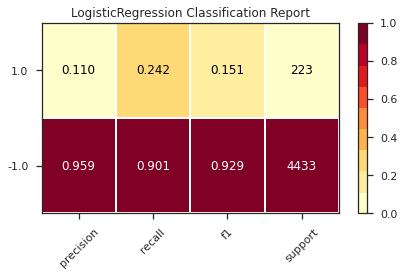

In [9]:
features_labels = [c for c in df_sex.columns if c not in ['uf','user', 'sexo']]
df_sex_model_data = pd.get_dummies(df_sex[features_labels].dropna(), prefix_sep='_', drop_first=False, dtype='int8')

# Uso do PowerTransformer por conta dos outliers vistos na análise do dataset
scaler = PowerTransformer()
scaler.fit(df_sex_model_data.values)

# Aplicação da transformação no dataset
df_sex_model_data[df_sex_model_data.columns] = scaler.transform(df_sex_model_data.values)
df_sex_model_data['sexo'] = df_sex.sexo
df_sex_model_data = df_sex_model_data.dropna()

#Separação dos sets e treino do reg logístico
X = df_sex_model_data.iloc[:,0:-1]
Y = df_sex_model_data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
dist = {-1 : 0.09, 1 : 0.91}

logreg = LogisticRegression(solver = 'newton-cg', class_weight = dist, n_jobs=-1)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

visualizer = ClassificationReport(logreg, support=True)

visualizer.fit(X_train, y_train)     
visualizer.score(X_test, y_test)    
visualizer.show() 

* Um pouco melhor do que simplesmente usar a distribuição ou distribuir M (baseado na grande maioria)

In [10]:
#Fazendo as inferências baseadas no modelo treinado
df_sex_predictor = pd.get_dummies(df_sex[features_labels], prefix_sep='_', drop_first=False, dtype='int8')
df_sex_predictor[df_sex_predictor.columns] = scaler.transform(df_sex_predictor.values)
df_sex_predictor['sexo'] = df_raw['sexo'].values

raw_sex_list = list()
for i,item in enumerate(df_sex_predictor.itertuples(),0):
    if item.sexo==1 or item.sexo==-1:
        raw_sex_list.append(int(item.sexo))
    else:
        raw_sex_list.append(int(logreg.predict(np.array(df_sex_predictor.iloc[i,0:-1]).reshape(1, -1))[0]))

#Atualizando os datasets        
df_sex_predictor['sexo'] = raw_sex_list
treated_df['sexo'] = raw_sex_list

## 1.4.3 Tratamento dos dados faltantes nos estados

* Aqui as coisas ficam um pouco mais complicadas. Vamos distribuir os dados faltantes baseados na distribuição também, mas antes vamos agrupar em níveis para diminuir o erro.

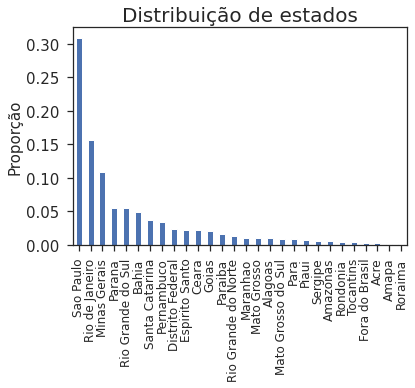

In [11]:
plt.title('Distribuição de estados', fontsize = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 15)
plt.ylabel('Proporção', fontsize = 15)
df_raw.uf.value_counts(normalize=True).plot(kind='bar')

* O sudeste soma quase 60% dos dados

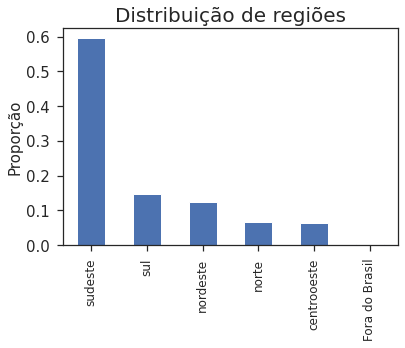

In [12]:
#Vamos separar essa coluna em sudeste, sul e então outros
SUDESTE = ['Sao Paulo', 'Minas Gerais', 'Rio de Janeiro', 'Espirito Santo']
SUL = ['Parana', 'Rio Grande do Sul', 'Santa Catarina']
NORDESTE = ['Bahia', 'Paraiba','Rio Grande do Norte' 'Maranhao', 'Pernambuco','Ceara', 'Sergipe']
CENTROOESTE = ['Mato Grosso', 'Mato Grosso do Sul', 'Distrito Federal', 'Goias']
NORTE = [s for s in df_raw.uf.value_counts().keys() if s not in SUDESTE and s not in SUL and s not in NORDESTE and s not in CENTROOESTE and s!='Fora do Brasil']

df_uf = df_raw.copy()
for i, item in enumerate(df_raw.itertuples(),0):
    if item.uf in SUDESTE:
        df_uf.iloc[i, 2] = 'sudeste'
    if item.uf in SUL:
        df_uf.iloc[i, 2] = 'sul'
    if item.uf in NORDESTE:
        df_uf.iloc[i, 2] = 'nordeste'
    if item.uf in CENTROOESTE:
        df_uf.iloc[i, 2] = 'centrooeste'
    if item.uf in NORTE:
        df_uf.iloc[i, 2] = 'norte'
    else: pass
    
plt.title('Distribuição de regiões', fontsize = 20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 15)
plt.ylabel('Proporção', fontsize = 15)
df_uf.uf.value_counts(normalize=True).plot(kind='bar')


    

In [13]:
regions = df_uf.uf.value_counts(normalize=True).keys().to_list()
prob_regions = df_uf.uf.value_counts(normalize=True).to_list()

regs = list()

#Aplicando a distribuição somente onde houver dado faltante ou outlier
for item in df_uf.itertuples():
    if str(item.uf)!='nan':
        regs.append(item.uf)
    else:
        regs.append(np.random.choice(regions,1,p=prob_regions)[0])
        
df_uf['uf'] = regs
treated_df['uf'] = regs
treated_df_bckp = treated_df.copy()

## 1.5 Dados tratados

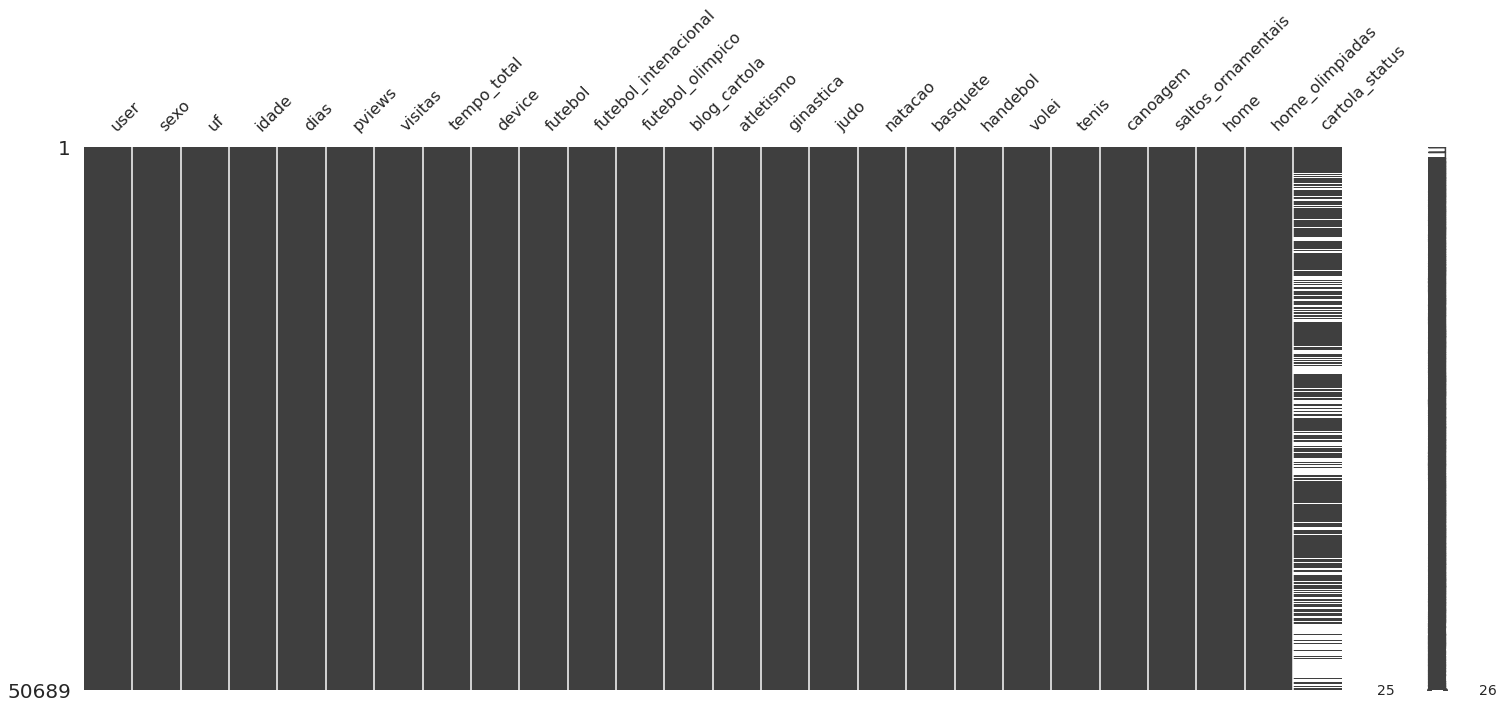

In [14]:
msno.matrix(treated_df)

# 2.0 Análise dos dados

* Vamos avaliar as distribuições dos assinantes, considerando o dataset bruto, a princípio.
* A avaliação e confirmação de algumas informações vamos tirar com a análise de explicabilidade do modelo treinado com as nossas correções. 
    * É um cuidado extra com os erros inseridos com as correções dos dados faltantes.

## 2.1 Idade

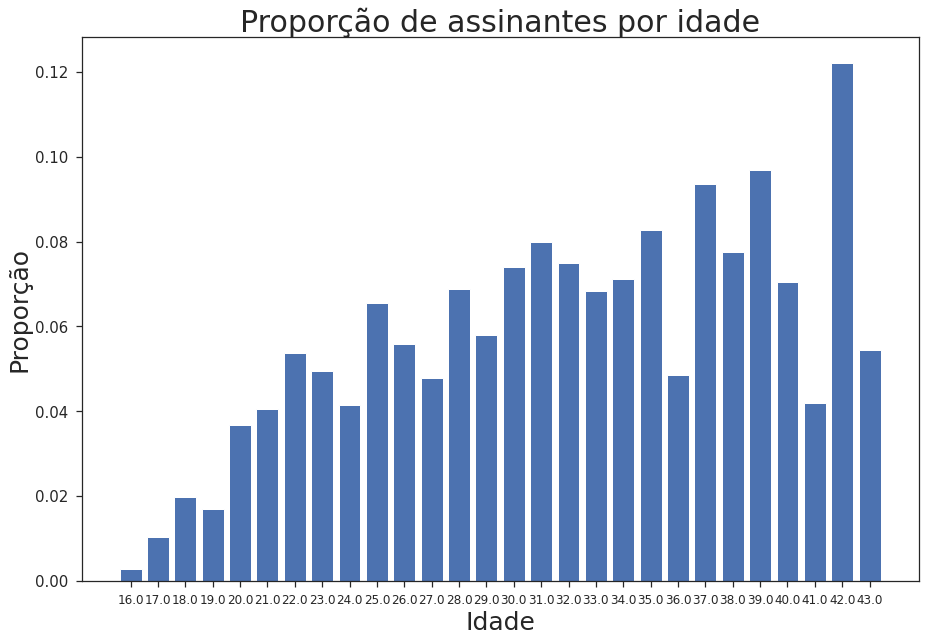

In [15]:
#relação entre idade e assinantes considerando a proporção de cada idade
assinantes = df_raw[df_raw['cartola_status']=='Cartola Pro'].idade.value_counts(sort = True).sort_index().to_dict()
df_prop_idade = df_raw[df_raw['cartola_status'].isna()==False]
df_prop_idade = df_prop_idade[df_prop_idade['cartola_status']!='Não Cartola']
total = df_prop_idade.idade.value_counts(sort = True).sort_index().to_dict()

prop_idade_assinantes = dict()
for key in assinantes.keys():
    if total[key]>100:
        prop_idade_assinantes[key] = assinantes[key]/total[key]


fig, ax = plt.subplots(figsize=(15, 10))
plt.title('Proporção de assinantes por idade', fontsize = 30)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 15)
plt.ylabel('Proporção', fontsize = 25)
plt.xlabel('Idade', fontsize = 25)
plt.bar(range(len(prop_idade_assinantes)), list(prop_idade_assinantes.values()), align='center')
plt.xticks(range(len(prop_idade_assinantes)), list(prop_idade_assinantes.keys()))

plt.show()

* **Importante:** as proporções acima consideram o total de determinada idade, sendo a relação entre assinantes e a quantidade total de cada idade no dataset.
* Com isso tratamos os problemas de probabilidade devido à distribuição desigual entre as idades.

## 2.1 Gênero

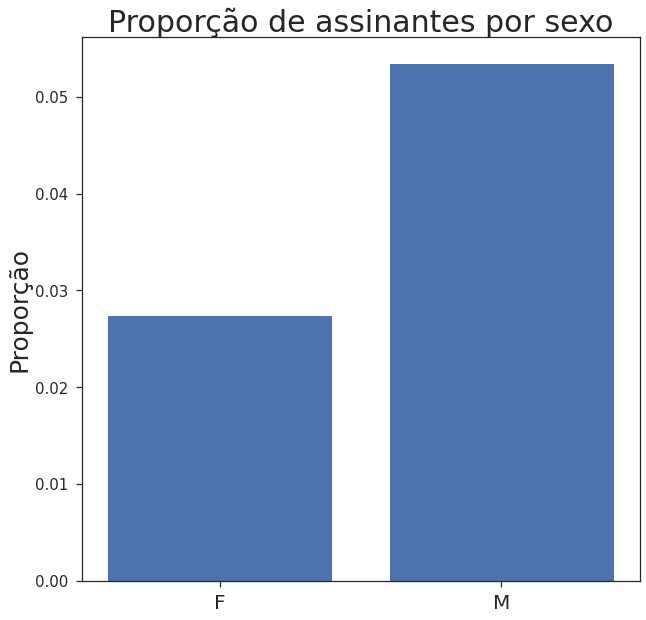

In [16]:
#relação entre sexo e assinantes considerando a proporção de cada idade
assinantes = df_raw[df_raw['cartola_status']=='Cartola Pro'].sexo.value_counts(sort = True).sort_index().to_dict()
df_prop_sexo = df_raw[df_raw['cartola_status'].isna()==False]
df_prop_sexo = df_prop_sexo[df_prop_sexo['cartola_status']!='Não Cartola']
total = df_prop_sexo.sexo.value_counts(sort = True).sort_index().to_dict()

prop_sexo_assinantes = dict()
for key in assinantes.keys():
    if total[key]>100:
        prop_sexo_assinantes[key] = assinantes[key]/total[key]

fig, ax = plt.subplots(figsize=(10, 10))
plt.xticks(range(len(prop_sexo_assinantes)), list(prop_sexo_assinantes.keys()))
plt.title('Proporção de assinantes por sexo', fontsize = 30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 15)
plt.ylabel('Proporção', fontsize = 25)
plt.bar(range(len(prop_sexo_assinantes)), list(prop_sexo_assinantes.values()), align='center')
plt.show()

* **Importante:** as proporções acima consideram o total de determinada idade, sendo a relação entre assinantes e a quantidade total de cada idade no dataset.
* Com isso tratamos os problemas de probabilidade devido à distribuição desigual entre as idades.

## 2.3 Unidades da Federação

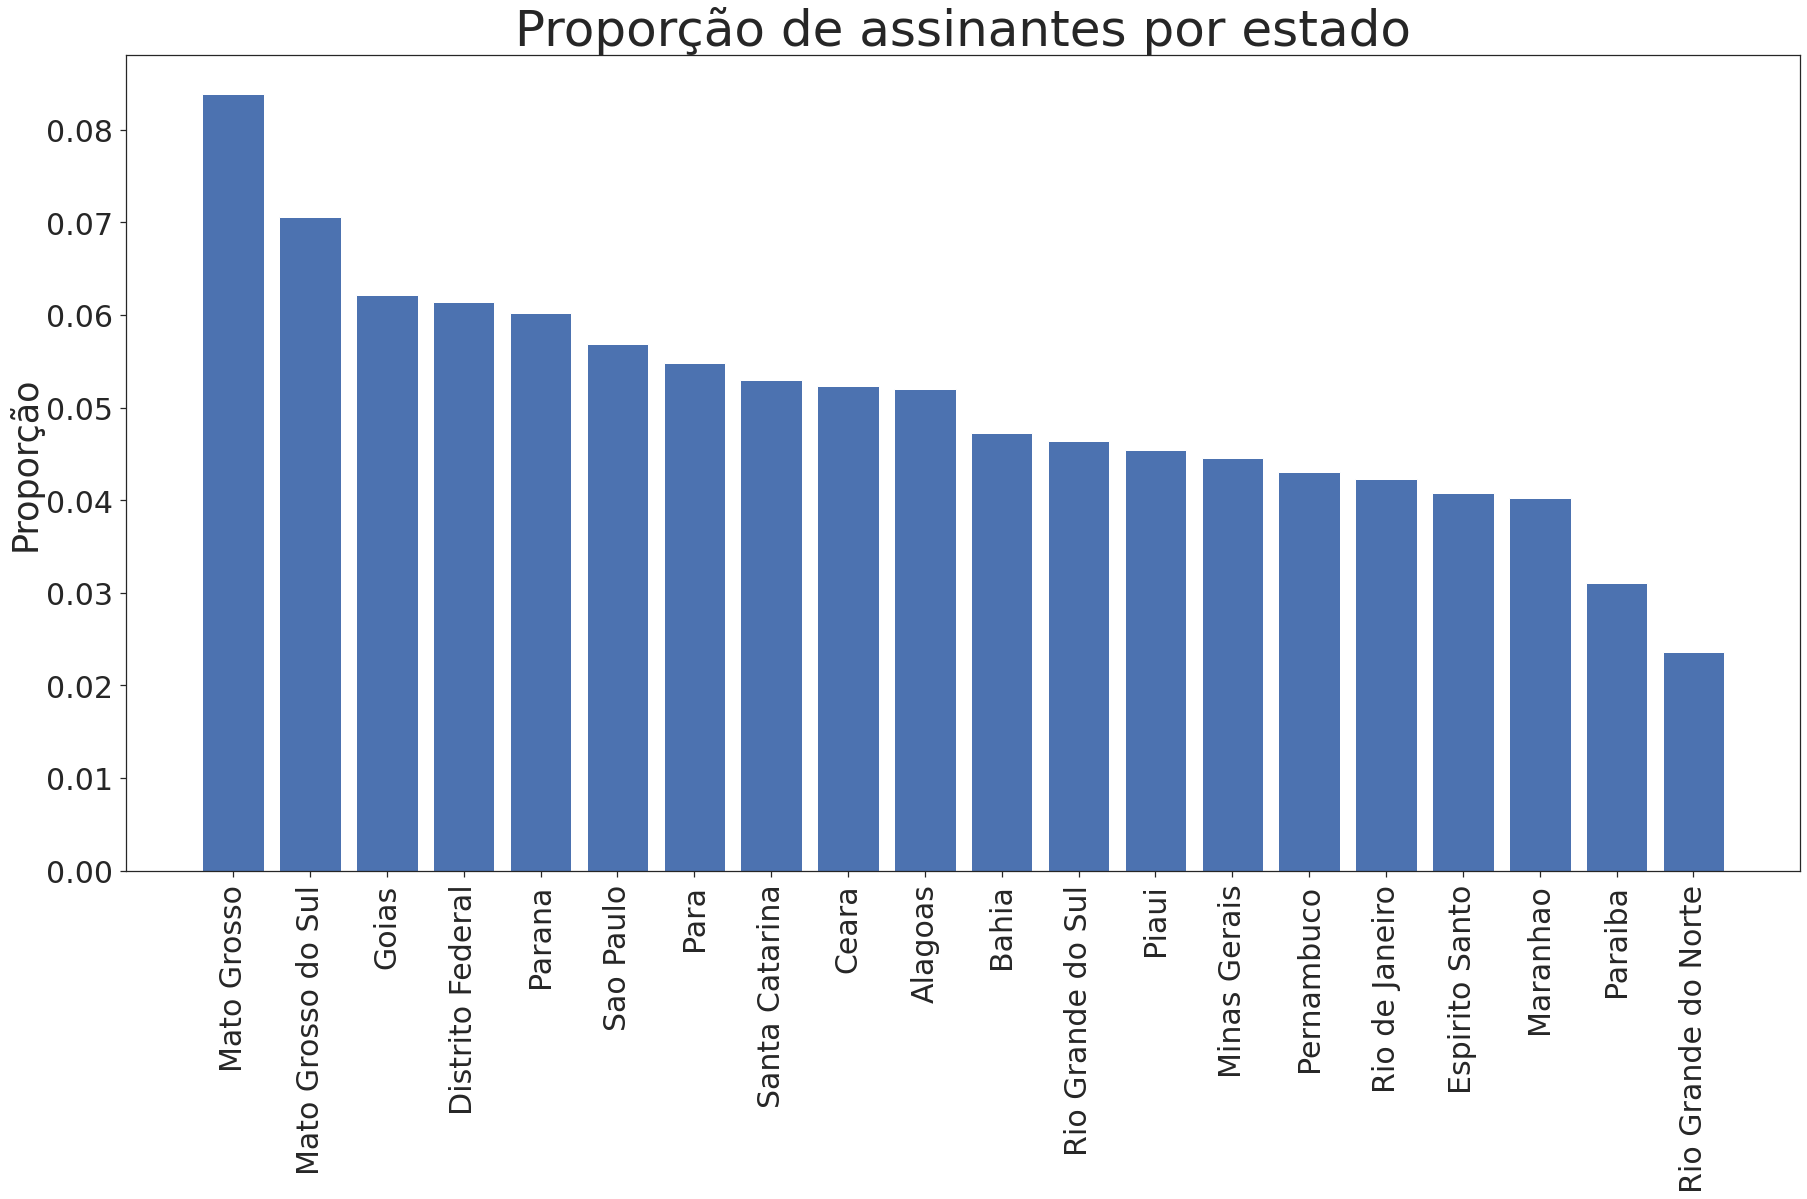

In [17]:
#relação entre o estado e assinantes considerando a proporção de cada estado
assinantes = df_raw[df_raw['cartola_status']=='Cartola Pro'].uf.value_counts(sort = True).sort_index().to_dict()
df_prop_uf = df_raw[df_raw['cartola_status'].isna()==False]
df_prop_uf = df_prop_uf[df_prop_uf['cartola_status']!='Não Cartola']
total = df_prop_uf.uf.value_counts(sort = True).sort_index().to_dict()

prop_uf_assinantes = dict()
for key in assinantes.keys():
    if total[key]>100:
        prop_uf_assinantes[key] = assinantes[key]/total[key]
prop_uf_assinantes = {k: v for k, v in sorted(prop_uf_assinantes.items(), key=lambda item: item[1], reverse = True)}

fig, ax = plt.subplots(figsize=(30, 15))

plt.bar(range(len(prop_uf_assinantes)), list(prop_uf_assinantes.values()), align='center')
plt.xticks(range(len(prop_uf_assinantes)), list(prop_uf_assinantes.keys()), fontsize=30, rotation = 'vertical')
plt.yticks(fontsize=25)
plt.title('Proporção de assinantes por estado', fontsize = 50)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.ylabel('Proporção', fontsize = 35)
plt.show()

* **Importante:** as proporções acima consideram o total de determinada idade, sendo a relação entre assinantes e a quantidade total de cada idade no dataset.
* Com isso tratamos os problemas de probabilidade devido à distribuição desigual entre as idades.

## 2.4 Correlações

* Vamos cuidar dos outliers antes:

In [18]:
treated_df = treated_df_bckp.dropna()
treated_df = pd.get_dummies(treated_df[treated_df['cartola_status']!='Não Cartola'], prefix_sep='_', drop_first=False, dtype='int8')
filter_columns = [x for x in treated_df.columns if x!='user' and x!='cartola_status_Cartola Free']
treated_df = treated_df[filter_columns]

# Uso do PowerTransformer por conta dos outliers vistos na análise do dataset
columns = [c for c in treated_df.columns if not c.startswith('cartola_status')]
scaler = PowerTransformer()
scaler.fit(treated_df[columns].values)

# Aplicação da transformação no dataset
treated_df[columns] = scaler.transform(treated_df[columns].values)

### 2.4.1 Linear (Pearson)

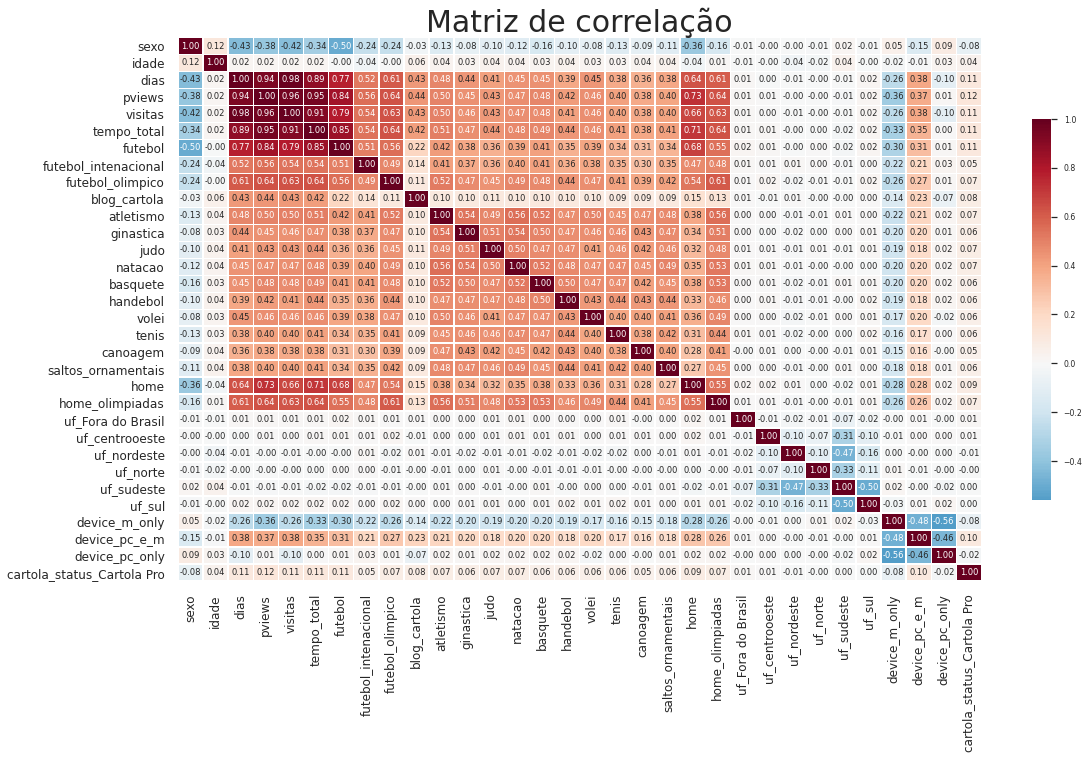

In [19]:
sns.set(font_scale=0.7) 
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(
    treated_df.corr(),
    vmax=1.0,
    center=0,
    fmt='.2f',
    annot=True,
    square=False,
    linewidths=.5,
    cbar_kws={"shrink": .70},
    cmap="RdBu_r"
)
plt.title('Matriz de correlação', fontsize = 30)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()

* As correlações lineares não são muito fortes, mas ainda assim podemos aproveitá-las.
* Vamos verificar as correlações não lineares

### 2.4.2 Não linear

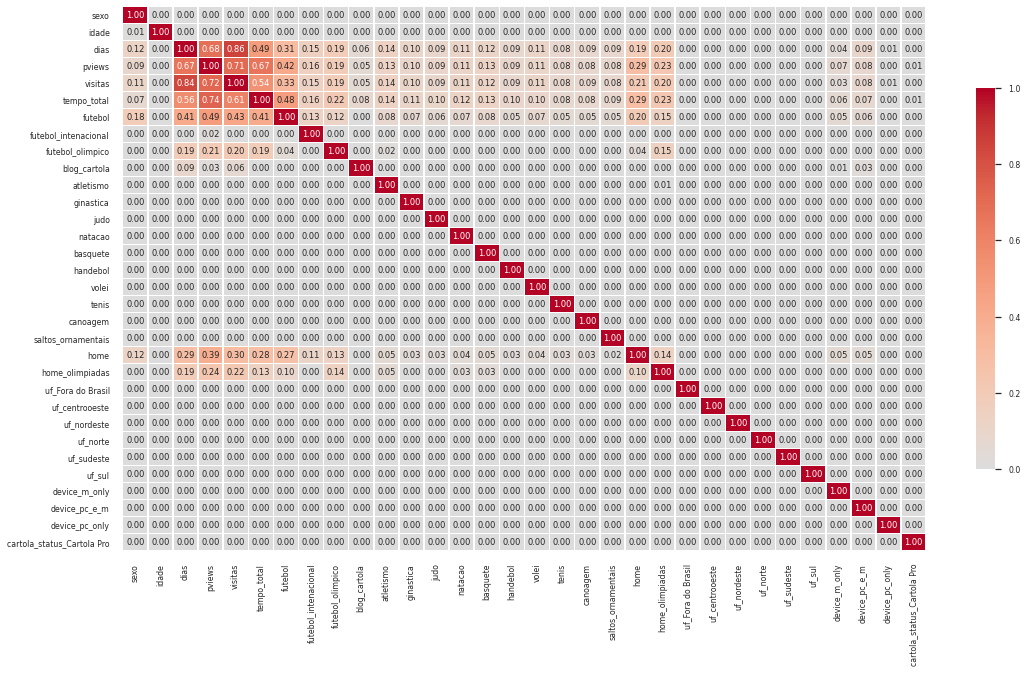

In [20]:
# Matriz da Predictive Power Score das features
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(
    pps.matrix(treated_df),
    vmax=1.0,
    center=0,
    fmt='.2f',
    square=False,
    linewidths=.5,
    annot=True,
    cbar_kws={"shrink": .70},
    cmap="coolwarm"
)

plt.show()

* Negativo para correlações não lineares.

# 3.0 Treino do modelo

## 3.1 Preprocessing

* Já possuímos um dataset com dados preprocessados para o treinamento, que realizamos durante as fases anteriores:
    * Dados faltantes
    * Normalização
    * Outliers
    * Tratamento de variáveis categóricas

## 3.2 Escolha do modelo e criação da função de treino

* Baseado em características que coletamos até aqui:
    * As corerelações são fracas, mas existentes;
    * As correlação são lineares;
    * A variável de interesse é categórica e dicotômica;
    * A variável de interesse é desbalanceada

* Utilizaremos Gradient Boost Tree (XGBoost).
    * Maior explicabilidade do modelo nos ajudará com a análise dos dados e suas correlações;
    * Função objetivo: Regressor Logístico -> corr lineares, classificação binária;
    * Aprendizado com coeficientes balanceados para as classes com implementação pouco custosa;

In [21]:
#Separação dos sets
X = treated_df.iloc[:,0:-1]
Y = treated_df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


#Função de treino
def train_model(gamma, learning_rate,max_depth,min_child_weight,
                    scale_pos_weight,reg_alpha,reg_lambda,subsample, final=False):
    model = XGBClassifier(objective ='binary:logistic',
            gamma=gamma,
            learning_rate=learning_rate,
            feature_selector = 'thrifty',
            scale_pos_weight = int(scale_pos_weight),
            max_depth=int(max_depth),
            min_child_weight=min_child_weight,
            n_estimators=5000,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            subsample=subsample,
            seed=42,
            nthread = 8,
            eval_metric = 'error')
    model.fit(X_train, y_train)
    if final==False:
        y_pred = model.predict(X_test)
        return balanced_accuracy_score(y_test, y_pred)
    else:
        return model

## 3.3 Otimização de hiperparâmetros

In [22]:
#Otimizador com maximizador bayesiano
pbounds = {'gamma':(10,15),
            'learning_rate':(0.001,0.007),
            'max_depth': (1,5),
            'min_child_weight':(30,40),
           'scale_pos_weight':(26,31),
            'reg_alpha':(30,40),
            'reg_lambda':(0,6),
            'subsample':(0.5,0.8),}
optimizer = BayesianOptimization(
f=train_model,pbounds=pbounds,random_state=42,)

def bay_optimizer(optimizer):
    optimizer.maximize(
    init_points=3,
    n_iter=20,)

#bay_optimizer(optimizer)

## 3.4 Fit do modelo com os parametros obtidos do otimizador

In [23]:
model = train_model( 10.0, 0.004382,1,40,
               30,39.93,0 ,0.8, final=True) 

## 3.5 Métricas

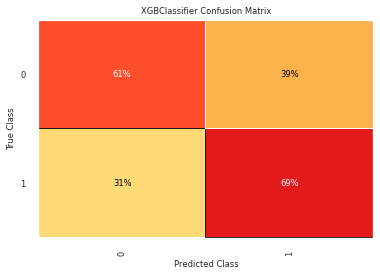

In [24]:
cm = ConfusionMatrix(model, classes=[0,1], percent = True)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

* Apesar da baixa correlação e da falta de feature engineering, conseguimos identificar as classes relativamente bem;
* Importante notar: recall mais alto para a defaulter. 
    * Enquanto accertamos 70% dos que realmente assinaram, ainda existem pessoas que assinariam o produto, mas ainda não assinaram.

In [25]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.98      0.61      0.75      8712
           1       0.06      0.69      0.11       317

    accuracy                           0.61      9029
   macro avg       0.52      0.65      0.43      9029
weighted avg       0.95      0.61      0.73      9029



## 3.6 Explicabilidade

* Vamos usar o modelo aditivo de Shapley para verificar as importâncias de cada variável na predição

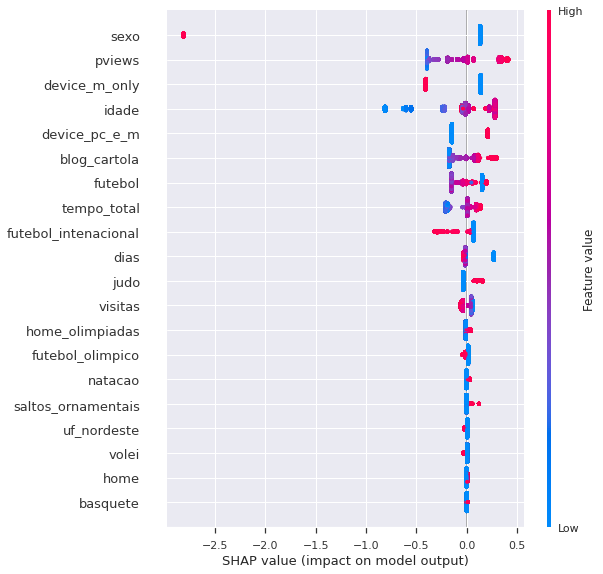

In [26]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

## 3.7 Melhorias

* Vários pontos a melhorar:
    * Feature engineering;
    * Comparação com outros modelos;
    * Cross validation;
    * Resampling do defaulter;
    * Análise do erro induzido das correções;
    

# 4.0 Considerações Finais
* O que não foi justificado durante a execução nesse notebook, será justificado na apresentação em anexo;
* Fico à disposição para sanar qualquer dúvida.